## Music genre classifier
- normalizovat data 
- feature engineering
- doplnit tokenizovany text do features listu,
- skusit ine klasifikatory(random forest)
- grid search
- dokumentacia


In [233]:
import pandas as pd
import numpy as np

import os
from os import path
from os import getcwd

from matplotlib import pyplot as plt
import seaborn as sb

import sklearn
from sklearn import tree
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import RandomizedSearchCV

import nltk
from nltk.corpus import stopwords

from scipy import stats
from scipy import misc

import io
import pydotplus
import graphviz
import warnings


#nltk.download()
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

### Data processing
- load data
- erase unimportant column
- show genre distribution
- print genres
- balance genre distribution

C:\Users\jakub\Desktop\MichalKodiDodzaleny\..\msd_genre_dataset.txt
['classic pop and rock' 'punk' 'folk' 'pop' 'dance and electronica'
 'metal' 'jazz and blues' 'classical' 'hip-hop' 'soul and reggae']
23895 3200 13192 1617 4935 2103 4334 1874 434 4016 

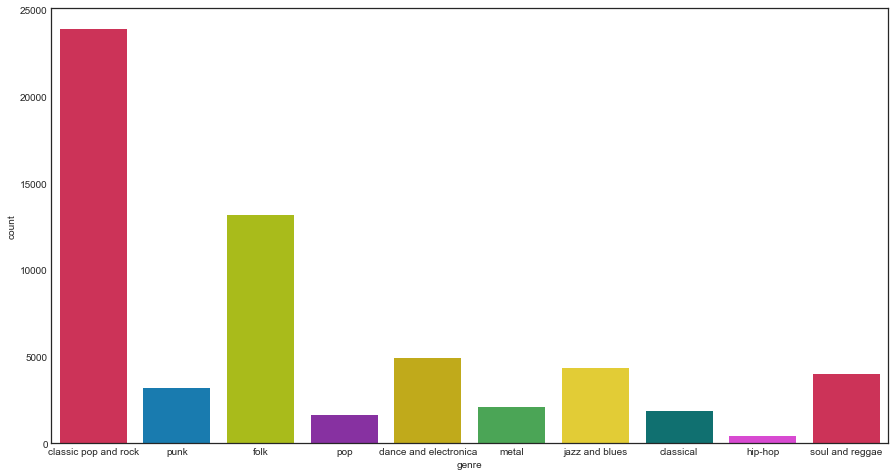

In [195]:
data_filename = path.join(getcwd(), '..', 'msd_genre_dataset.txt')
print(data_filename)
pandas_data = pd.read_csv(data_filename, header=0)
del pandas_data['track_id']
pandas_data.rename(columns={'%genre': 'genre'}, inplace=True)

red_blue = ['#e6194b', '#0082c8','#bdd600','#911eb4', '#dbbe00', '#3cb44b','#ffe119','#008080', '#f032e6']
palette = sb.color_palette(red_blue)
sb.set_palette(palette)
sb.set_style('white')
fig = plt.figure(figsize=(15,8))
sb.countplot(x="genre", data=pandas_data, palette=red_blue)

genre_column = pandas_data['genre']
genres = genre_column.unique()
print(genres)

for genre in genres:
    print(len(pandas_data[(pandas_data['genre'] == genre)]), end=" ")

In [196]:
poprock = sklearn.utils.shuffle(pandas_data[pandas_data['genre'] == 'classic pop and rock'])
folk = sklearn.utils.shuffle(pandas_data[pandas_data['genre'] == 'folk'])

poprock = poprock[:int(5000)]
folk = folk[:int(5000)]

pandas_data = pandas_data.drop(pandas_data[pandas_data['genre'] == 'classic pop and rock'].index)
pandas_data = pandas_data.drop(pandas_data[pandas_data['genre'] == 'folk'].index)


for genre in genres:
    print(len(pandas_data[(pandas_data['genre'] == genre)]), end=" ")

0 3200 0 1617 4935 2103 4334 1874 434 4016 

5000 3200 5000 1617 4935 2103 4334 1874 434 4016 

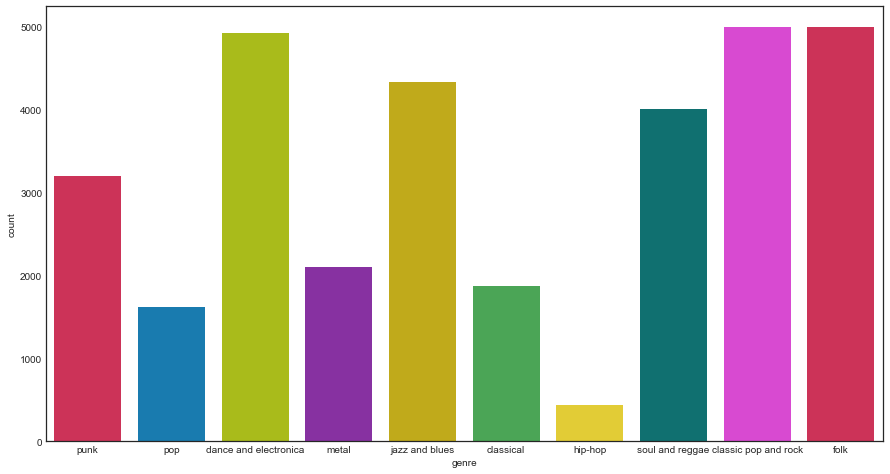

In [197]:
frames = [pandas_data, poprock, folk]
df = pd.concat(frames)

#df.info()

figSec = plt.figure(figsize=(15,8))
sb.countplot(x="genre", data=df, palette=red_blue)

for genre in genres:
    print(len(df[(df['genre'] == genre)]), end=" ")

### Features adjusment
- tokenize and remove stop words from title
- tokenize and remove stop words from artist name

In [179]:
df['tokenized_title'] = df.apply(lambda row: nltk.word_tokenize(row['title']), axis=1)
#df['tokenized_artist_name'] = df.apply(lambda row: nltk.word_tokenize(row['artist_name']), axis=1)
stop_words = stopwords.words('english')

#for i,row in pandas_data.iterrows():
#    print(row.tokenized_title)
#    row.tokenized_title = [word for word in row.tokenized_title if not word.lower() in stop_words and word.isalpha()]
#    print(row.tokenized_title)

def removeStopWors(words):
    out = [word for word in words if not word.lower() in stop_words and word.isalpha()]
    return out

df['tokenized_title'] = df.apply(lambda row: removeStopWors(row['tokenized_title']), axis=1)
#df['tokenized_artist_name'] = df.apply(lambda row: removeStopWors(row['tokenized_artist_name']), axis=1)

for genre in genres:
    print(len(df[(df['genre'] == genre)]), end=" ")
    
df

5000 3200 5000 1617 4935 2103 4334 1874 434 4016 

,genre,artist_name,title,loudness,tempo,time_signature,key,mode,duration,avg_timbre1,...,var_timbre5,var_timbre6,var_timbre7,var_timbre8,var_timbre9,var_timbre10,var_timbre11,var_timbre12,artist_name2,tokenized_title
58383,soul and reggae,Jackie Mittoo,Pease Treaty,-12.019,132.057,4,2,1,152.76363,39.154124,...,1111.004173,2686.314331,1464.902666,928.641014,808.031601,951.733225,604.975521,624.226520,1230,"[Pease, Treaty]"
31341,folk,The Duhks,True Religion,-12.937,131.677,4,6,0,254.77179,38.358584,...,987.422181,1936.178290,767.763310,613.837881,484.753388,436.317506,557.086894,578.299163,2541,"[True, Religion]"
18016,classic pop and rock,Velvet Revolver,Gravedancer,-6.132,69.532,4,5,1,520.41098,47.810035,...,794.256125,462.598656,517.970110,401.831912,379.275401,253.289008,172.952061,243.379074,2828,[Gravedancer]
42382,dance and electronica,Freeland,We Want Your Soul,-7.702,125.996,4,7,1,373.49832,43.817720,...,1799.446111,1324.637728,627.005548,782.794592,391.941988,426.768786,478.221949,307.017334,984,"[Want, Soul]"
42049,dance and electronica,Dislocation Dance,Narrow Laughs,-10.519,160.116,1,9,1,132.04853,43.392801,...,897.909242,642.001615,615.692614,746.219093,373.373563,342.960701,220.300925,271.383029,797,"[Narrow, Laughs]"
48130,metal,Overkill,Playing With Spiders/Skullkrusher (LP Version),-14.546,116.774,4,7,1,615.33995,37.505275,...,1201.286618,1029.961091,583.779412,426.103100,282.635002,289.917505,348.811685,174.527717,1907,"[Playing, LP, Version]"
49958,jazz and blues,Rahsaan Roland Kirk,Fly By Night (LP Version),-11.379,124.437,1,8,0,258.92526,40.480473,...,403.781195,1072.176472,437.651271,371.339609,229.990540,355.448281,235.631137,259.018215,2051,"[Fly, Night, LP, Version]"
24332,punk,59 Times the Pain,Neither Question Nor Disagree,-8.027,171.016,1,6,0,151.95383,47.421435,...,343.211898,511.598595,247.439630,233.878117,178.662948,148.458318,170.940996,188.605506,10,"[Neither, Question, Disagree]"
34774,folk,Jeff Lang,My Mother Always Talked to Me,-13.839,107.138,5,9,1,282.12200,35.966356,...,1562.951698,891.391001,622.779996,627.516150,576.685161,352.034684,345.770153,495.954404,1292,"[Mother, Always, Talked]"
32445,folk,Espers,Dead Queen,-6.903,69.269,5,2,0,493.21751,46.059114,...,2247.434896,502.541721,1138.124779,350.019988,432.063371,322.466450,165.568231,322.020239,905,"[Dead, Queen]"


In [104]:
#df.describe()

In [184]:
#df.info()
#df["artist_name"].value_counts()

In [198]:
lb_make = LabelEncoder()
df["artist_name"] = lb_make.fit_transform(df["artist_name"])

### Data Visualisation
- visualise data by histogram and boxplot
- remove outliers, implemented two methods: IQR and Zscore, for more info: http://colingorrie.github.io/outlier-detection.html

Note: IQR redukovala dataset takmer na polovicu, preto som zvolil Z score ktore redukuje data set menej radikalne z 1800 na 1400 pre classical 

In [35]:
classical = df[df['genre'] == 'classical']
dance = df[df['genre'] == 'dance and electronica']
folk = df[df['genre'] == 'folk']
hiphop = df[df['genre'] == 'hip-hop']
jazz = df[df['genre'] == 'jazz and blues']
metal = df[df['genre'] == 'metal']
pop = df[df['genre'] == 'pop']
poprock = df[df['genre'] == 'classic pop and rock']
punk = df[df['genre'] == 'punk']
reggae = df[df['genre'] == 'soul and reggae']

print(len(classical),len(dance),len(folk),len(hiphop),len(jazz),len(metal),len(pop),len(poprock),len(punk),len(reggae))


1874 4935 5000 434 4334 2103 1617 5000 3200 4016


In [140]:
#classical.plot(kind='box', subplots=True, layout=(11,3), sharex=False, sharey=False, figsize=(15, 40))
#plt.show()

In [141]:
#classical.hist(layout=(11,3), sharex=False, sharey=False, figsize=(15, 40))
#plt.show()

In [36]:
numerical = ['loudness', 'tempo', 'time_signature', 'key', 'mode', 'duration', 'avg_timbre1',
           'avg_timbre1','avg_timbre2','avg_timbre3','avg_timbre4','avg_timbre5','avg_timbre6',
           'avg_timbre9','avg_timbre8','avg_timbre9','avg_timbre10','avg_timbre11','avg_timbre12',
           'var_timbre1','var_timbre2','var_timbre3','var_timbre4','var_timbre5','var_timbre6',
           'var_timbre7','var_timbre8','var_timbre9','var_timbre10','var_timbre11','var_timbre12']

#------------------------------------------------------------------------------
# accept a dataframe, remove outliers, return cleaned data in a new dataframe
# see http://www.itl.nist.gov/div898/handbook/prc/section1/prc16.htm
# IQR method
#------------------------------------------------------------------------------
def iqr_remove_outlier(df_in, col_name):
    par = 3
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-par*iqr
    fence_high = q3+par*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

#for col in numerical:
#    classical = iqr_remove_outlier(classical, col)

#------------------------------------------------------------------------------
# accept a dataframe, remove outliers, return cleaned data in a new dataframe
# see http://colingorrie.github.io/outlier-detection.html
# Zscore method
#------------------------------------------------------------------------------
for col in numerical:
    classical = classical[((classical[col] - classical[col].mean()) / classical[col].std()).abs() < 3]
    dance = dance[((dance[col] - dance[col].mean()) / dance[col].std()).abs() < 3]
    folk = folk[((folk[col] - folk[col].mean()) / folk[col].std()).abs() < 3]
    hiphop = hiphop[((hiphop[col] - hiphop[col].mean()) / hiphop[col].std()).abs() < 3]
    jazz = jazz[((jazz[col] - jazz[col].mean()) / jazz[col].std()).abs() < 3]
    metal = metal[((metal[col] - metal[col].mean()) / metal[col].std()).abs() < 3]
    pop = pop[((pop[col] - pop[col].mean()) / pop[col].std()).abs() < 3]
    poprock = poprock[((poprock[col] - poprock[col].mean()) / poprock[col].std()).abs() < 3]
    punk = punk[((punk[col] - punk[col].mean()) / punk[col].std()).abs() < 3]
    reggae = reggae[((reggae[col] - reggae[col].mean()) / reggae[col].std()).abs() < 3]
    
print(len(classical),len(dance),len(folk),len(hiphop),len(jazz),len(metal),len(pop),len(poprock),len(punk),len(reggae))
    

1425 3563 3813 328 3342 1524 1224 3808 2313 3092


In [39]:
frames = [classical, dance, folk, hiphop, jazz, metal, pop, poprock, punk, reggae]
#frames = [classical, folk, hiphop, jazz, metal, pop, poprock, punk, reggae]
df2 = pd.concat(frames)

for genre in genres:
    print(len(df2[(df2['genre'] == genre)]), end=" ")

3808
2313
3813
1224
3563
1524
3342
1425
328
3092


In [142]:
#classical.hist(layout=(11,3), sharex=False, sharey=False, figsize=(15, 40))
#plt.show()

In [143]:
#classical.plot(kind='box', subplots=True, layout=(11,3), sharex=False, sharey=False, figsize=(15, 40))
#plt.show()

### All together

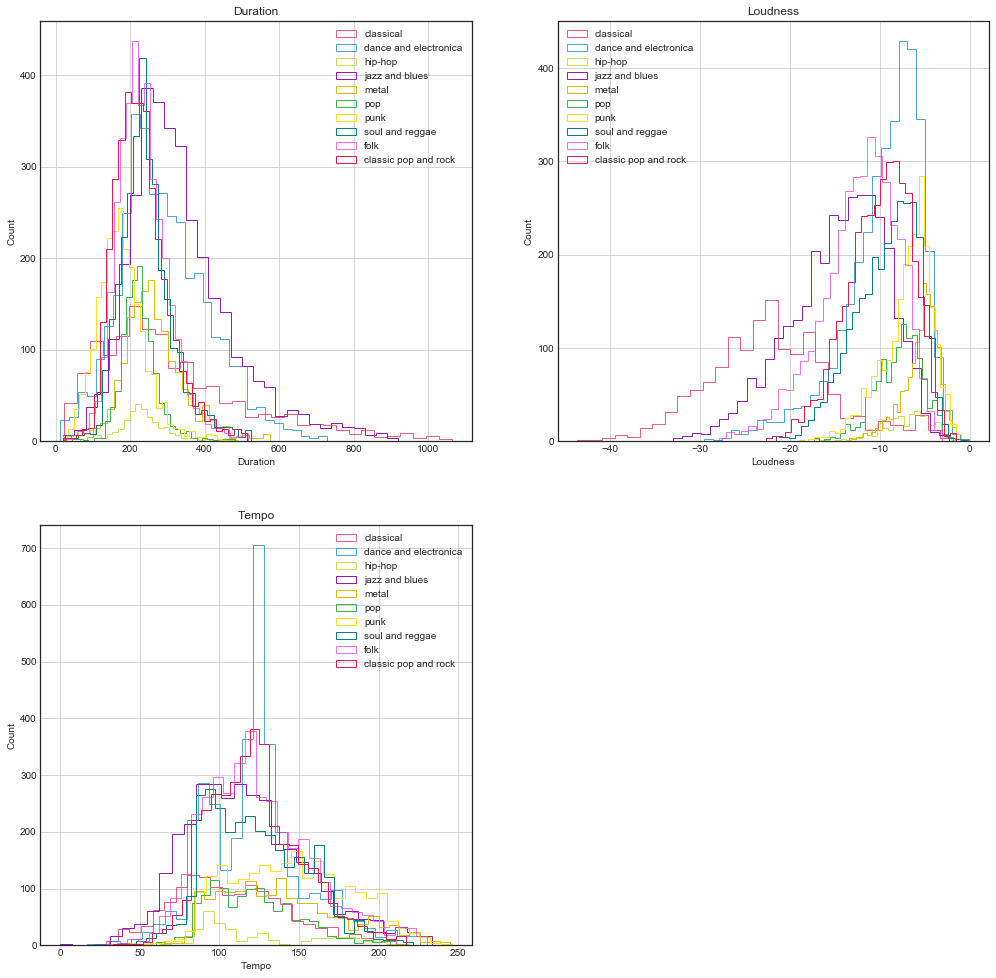

In [9]:
fig2 = plt.figure(figsize=(17, 17))

#Duration 
ax1 = fig2.add_subplot(221)
ax1.set_xlabel('Duration')
ax1.set_ylabel('Count')
ax1.set_title('Duration')
classical['duration'].hist(alpha=0.7, bins = 30, label='classical',histtype='step')
dance['duration'].hist(alpha=0.7, bins = 30, label='dance and electronica',histtype='step')
hiphop['duration'].hist(alpha=0.7, bins = 30, label='hip-hop',histtype='step')
jazz['duration'].hist(alpha=1, bins = 30, label='jazz and blues',histtype='step')
metal['duration'].hist(alpha=1, bins = 30, label='metal',histtype='step')
pop['duration'].hist(alpha=1, bins = 30, label='pop',histtype='step')
punk['duration'].hist(alpha=1, bins = 30, label='punk',histtype='step')
reggae['duration'].hist(alpha=1, bins = 30, label='soul and reggae',histtype='step')
folk['duration'].hist(alpha=0.7, bins = 30, label='folk',histtype='step')
poprock['duration'].hist(alpha=1, bins = 30, label='classic pop and rock',histtype='step')
plt.legend(loc = "upper right")

#Loudness
ax2 = fig2.add_subplot(222)
ax2.set_xlabel('Loudness')
ax2.set_ylabel('Count')
ax2.set_title('Loudness')
classical['loudness'].hist(alpha=0.7, bins = 30, label='classical',histtype='step')
dance['loudness'].hist(alpha=0.7, bins = 30, label='dance and electronica',histtype='step')
hiphop['loudness'].hist(alpha=0.7, bins = 30, label='hip-hop',histtype='step')
jazz['loudness'].hist(alpha=1, bins = 30, label='jazz and blues',histtype='step')
metal['loudness'].hist(alpha=1, bins = 30, label='metal',histtype='step')
pop['loudness'].hist(alpha=1, bins = 30, label='pop',histtype='step')
punk['loudness'].hist(alpha=1, bins = 30, label='punk',histtype='step')
reggae['loudness'].hist(alpha=1, bins = 30, label='soul and reggae',histtype='step')
folk['loudness'].hist(alpha=0.7, bins = 30, label='folk',histtype='step')
poprock['loudness'].hist(alpha=1, bins = 30, label='classic pop and rock',histtype='step')
plt.legend(loc = "upper left")

#Tempo
ax3 = fig2.add_subplot(223)
ax3.set_xlabel('Tempo')
ax3.set_ylabel('Count')
ax3.set_title('Tempo')
classical['tempo'].hist(alpha=0.7, bins = 30, label='classical',histtype='step')
dance['tempo'].hist(alpha=0.7, bins = 30, label='dance and electronica',histtype='step')
hiphop['tempo'].hist(alpha=0.7, bins = 30, label='hip-hop',histtype='step')
jazz['tempo'].hist(alpha=1, bins = 30, label='jazz and blues',histtype='step')
metal['tempo'].hist(alpha=1, bins = 30, label='metal',histtype='step')
pop['tempo'].hist(alpha=1, bins = 30, label='pop',histtype='step')
punk['tempo'].hist(alpha=1, bins = 30, label='punk',histtype='step')
reggae['tempo'].hist(alpha=1, bins = 30, label='soul and reggae',histtype='step')
folk['tempo'].hist(alpha=0.7, bins = 30, label='folk',histtype='step')
poprock['tempo'].hist(alpha=1, bins = 30, label='classic pop and rock',histtype='step')
plt.legend(loc = "upper right")



### Training 
- kazdy classifier je obaleny wrapperom, OneVsRest co zabezpecuje dokompoziciu klasifikacie na serium binarnych klasifikacii, jedna trieda vs ostatne, opakovane podobne pre nasledovne triedy
- split dataset
- trian tree
- evaluate 

In [257]:
##taken from https://stackoverflow.com/questions/28200786/how-to-plot-scikit-learn-classification-report/34304414#34304414

def plot_classification_report(cr, title='Classification report ', with_avg_total=False, cmap=plt.cm.Blues):

    lines = cr.split('\n')

    classes = []
    plotMat = []
    for line in lines[2 : (len(lines) - 3)]:
        #print(line)
        t = line.split()
        # print(t)
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        #print(v)
        plotMat.append(v)

    if with_avg_total:
        aveTotal = lines[len(lines) - 1].split()
        classes.append('avg/total')
        vAveTotal = [float(x) for x in t[1:len(aveTotal) - 1]]
        plotMat.append(vAveTotal)


    plt.imshow(plotMat, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    x_tick_marks = np.arange(3)
    y_tick_marks = np.arange(len(classes))
    plt.xticks(x_tick_marks, ['precision', 'recall', 'f1-score'], rotation=45)
    plt.yticks(y_tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('Classes')
    plt.xlabel('Measures')

In [199]:
df = sklearn.utils.shuffle(df)

for genre in genres:
    print(len(df[(df['genre'] == genre)]), end=" ")
    
print()

test_df = df[:int(len(df)*0.2)]
train_df = df[int(len(df)*0.2):]

print(len(train_df))
print(len(test_df))


5000 3200 5000 1617 4935 2103 4334 1874 434 4016 
26011
6502


### Decision Tree Classifier

In [226]:
model1 = OneVsRestClassifier(DecisionTreeClassifier(min_samples_split=50))

In [227]:
features = ["artist_name",'loudness', 'tempo', 'time_signature', 'key', 'mode', 'duration', 'avg_timbre1',
           'avg_timbre1','avg_timbre2','avg_timbre3','avg_timbre4','avg_timbre5','avg_timbre6',
           'avg_timbre9','avg_timbre8','avg_timbre9','avg_timbre10','avg_timbre11','avg_timbre12',
           'var_timbre1','var_timbre2','var_timbre3','var_timbre4','var_timbre5','var_timbre6',
           'var_timbre7','var_timbre8','var_timbre9','var_timbre10','var_timbre11','var_timbre12',]

In [228]:
x_train = train_df[features]
y_train = train_df['genre']

x_test = test_df[features]
y_test = test_df['genre']

dt = model1.fit(x_train,y_train)

In [214]:
#def printTree(tree, features, path):
#    f = io.StringIO()
#    export_graphviz(tree, out_file=f, feature_names=features)
#    pydotplus.graph_from_dot_data(f.getvalue()).write_png(path)
#    img = misc.imread(path)
#    plt.rcParams['figure.figsize'] = (20,20)
#    plt.imshow(img)

#printTree(dt, features, 'tree01.png')

                       precision    recall  f1-score   support

 classic_pop_and_rock       0.36      0.35      0.36      1030
                 punk       0.70      0.64      0.67       393
                 folk       0.55      0.54      0.54       980
                  pop       0.47      0.50      0.49       985
dance_and_electronica       0.31      0.21      0.25        87
                metal       0.51      0.49      0.50       852
       jazz_and_blues       0.70      0.64      0.67       441
            classical       0.59      0.54      0.57       316
              hip-hop       0.58      0.58      0.58       632
      soul_and_reggae       0.54      0.64      0.59       786

          avg / total       0.52      0.52      0.52      6502



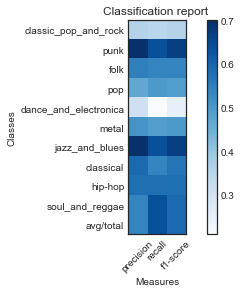

In [259]:
y_pred = model1.predict(x_test)
score = accuracy_score(y_test, y_pred)*100

classificationReport = classification_report(y_test, y_pred, target_names = ['classic_pop_and_rock', 'punk', 'folk', 'pop', 'dance_and_electronica',
 'metal', 'jazz_and_blues', 'classical', 'hip-hop', 'soul_and_reggae'])
print(classificationReport)

accuracy_score(y_test,y_pred)

plot_classification_report(classificationReport, with_avg_total=True)

### KNN Classifier

In [204]:
model2 = KNeighborsClassifier(n_neighbors=4)

In [205]:
x_train = train_df[features]
y_train = train_df['genre']

x_test = test_df[features]
y_test = test_df['genre']

model2.fit(x_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=4, p=2,
           weights='uniform')

                       precision    recall  f1-score   support

 classic_pop_and_rock       0.24      0.41      0.31      1030
                 punk       0.51      0.46      0.48       393
                 folk       0.40      0.35      0.37       980
                  pop       0.34      0.35      0.35       985
dance_and_electronica       0.18      0.07      0.10        87
                metal       0.45      0.38      0.41       852
       jazz_and_blues       0.62      0.54      0.58       441
            classical       0.26      0.18      0.21       316
              hip-hop       0.48      0.32      0.38       632
      soul_and_reggae       0.45      0.42      0.44       786

          avg / total       0.40      0.38      0.38      6502



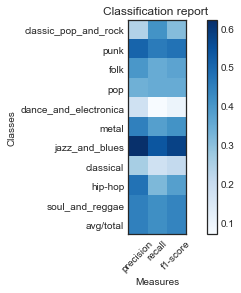

In [258]:
y_pred = model2.predict(x_test)
score = accuracy_score(y_test, y_pred)*100

classificationReport = classification_report(y_test, y_pred, target_names = ['classic_pop_and_rock', 'punk', 'folk', 'pop', 'dance_and_electronica',
 'metal', 'jazz_and_blues', 'classical', 'hip-hop', 'soul_and_reggae'])
print(classificationReport)

accuracy_score(y_test,y_pred)

plot_classification_report(classificationReport, with_avg_total=True)

### RandomForest Classifier

In [241]:
#param_dist = {"max_depth": [3, None],
#              "max_features": sp_randint(1, 11),
#              "min_samples_split": sp_randint(2, 11),
#              "min_samples_leaf": sp_randint(1, 11),
#              "bootstrap": [True, False],
#              "criterion": ["gini", "entropy"]}

model3 = OneVsRestClassifier(RandomForestClassifier(n_estimators=25))

In [242]:
x_train = train_df[features]
y_train = train_df['genre']

x_test = test_df[features]
y_test = test_df['genre']

model3.fit(x_train,y_train)

OneVsRestClassifier(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          n_jobs=1)

                       precision    recall  f1-score   support

 classic_pop_and_rock       0.45      0.37      0.41      1030
                 punk       0.81      0.74      0.77       393
                 folk       0.64      0.67      0.65       980
                  pop       0.53      0.68      0.60       985
dance_and_electronica       0.80      0.14      0.24        87
                metal       0.62      0.61      0.62       852
       jazz_and_blues       0.83      0.71      0.76       441
            classical       0.59      0.46      0.52       316
              hip-hop       0.66      0.66      0.66       632
      soul_and_reggae       0.57      0.68      0.62       786

          avg / total       0.61      0.60      0.60      6502



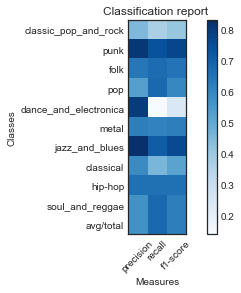

In [260]:
y_pred = model3.predict(x_test)

classificationReport = classification_report(y_test, y_pred, target_names = ['classic_pop_and_rock', 'punk', 'folk', 'pop', 'dance_and_electronica',
 'metal', 'jazz_and_blues', 'classical', 'hip-hop', 'soul_and_reggae'])
print(classificationReport)

accuracy_score(y_test,y_pred)

plot_classification_report(classificationReport, with_avg_total=True)